(sec:othello-agent)=
# オセロAIの作成

ここからは、より高度な強化学習の対象としてオセロを取り扱う。ご存じの通り、オセロは(諸説あるものの)日本で発祥した「はさみ碁」の一種で、白と黒のディスクを8×8の盤の上に並べ、同色で挟まれたディスクを裏返すことで、より多くのマスを獲得した方が勝利するというゲームである。

```{note}
オセロは日本以外ではリバーシのように呼ばれることがある。リバーシは初期状態として、ディスクが置かれていない状態からスタートするが、オセロは盤の中央に白黒2枚ずつのディスクを置いた状態からスタートする、という違いがある。

参考: [オセロ（ボードゲーム）- Wikipedia](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%BB%E3%83%AD_(%E3%83%9C%E3%83%BC%E3%83%89%E3%82%B2%E3%83%BC%E3%83%A0))
```

In [2]:
"""
Google Colab用の準備
"""

IN_COLAB = True
try:
    import google.colab

    print("You are running the code in Google Colab.")
except ImportError:
    IN_COLAB = False
    print("You are running the code on the local computer.")

if IN_COLAB:
    # othelloモジュールのインストール
    !pip install git+https://github.com/tatsy-classes/cothello.git@v2.1.0

You are running the code on the local computer.


In [ ]:
import time
import random
import contextlib
import multiprocessing as mp

import numpy as np
import seaborn as sns
import IPython.display as display
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from matplotlib.animation import ArtistAnimation

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: None

rc = {"figure.dpi": 150}
sns.set_theme(style="white", rc=rc)

# 乱数シードの固定
random.seed(12345)
np.random.seed(12345)

# 実験に用いるエピソード数
n_episodes = 100
glue("n_episodes", n_episodes)

# 並列化スレッド数
n_jobs = min(4, mp.cpu_count())

100

In [ ]:
@contextlib.contextmanager
def tqdm_joblib(total, callback=None, **kwargs):
    import joblib

    progress_bar = tqdm(total=total, smoothing=0, **kwargs)

    class TqdmBatchCompletionCallBack(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, out):
            super(TqdmBatchCompletionCallBack, self).__call__(out)
            with self.parallel._lock:
                if callback is not None:
                    if hasattr(self, "_result"):
                        for r in self._result:
                            callback(progress_bar, *r)
                progress_bar.update(n=self.batch_size)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallBack

    try:
        yield progress_bar
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        progress_bar.close()

In [ ]:
import othello
from othello import Player

b_win = 0
w_win = 0
draw = 0


def check(p1_fn, p2_fn):
    global b_win, w_win, draw
    b_win = 0
    w_win = 0
    draw = 0

    def game(p1_fn, p2_fn):
        # ゲームのリセット
        env = othello.make()
        env.reset()

        # 手番を決定
        first_is_p1 = np.random.random() < 0.5
        if not first_is_p1:
            p1_fn, p2_fn = p2_fn, p1_fn

        # エピソード開始
        while not env.is_done():
            # 有効手の列挙
            actions = env.legal_actions()

            # 手番のプレイヤーによる行動の選択
            if env.player.is_black():
                action = p1_fn(env)
            else:
                action = p2_fn(env)

            # 着手による盤の状態の更新
            env.update(action)

        n_black = env.count(Player.BLACK)
        n_white = env.count(Player.WHITE)

        if not first_is_p1:
            n_black, n_white = n_white, n_black

        return n_black, n_white

    # joblibを用いて並列で対戦する
    def callback(pbar, *args):
        global b_win, w_win, draw

        n_black, n_white = args
        if n_black > n_white:
            b_win += 1
        elif n_black < n_white:
            w_win += 1
        else:
            draw += 1

        pbar.set_description(f"B:{b_win:d}, W:{w_win:d}, D:{draw:d}")

    with tqdm_joblib(total=n_episodes, callback=callback):
        Parallel(n_jobs=n_jobs, batch_size=1)(
            delayed(game)(p1_fn, p2_fn) for _ in range(n_episodes)
        )

## オセロゲーム環境

### オセロモジュールのインストール

今回は、講義用に用意したオセロ用のゲーム環境を用いる。ゲーム環境用のモジュールは以下のURLからダウンロードできる。

<https://github.com/tatsy-classes/cothello/releases/>

このURLにはPython3.9用のインストールパッケージ (Wheel)がOSごとに用意されている。Windows, Linuxの場合はそれぞれ対応するものを、MacOSの場合はM1, M2等のCPUを持つモデルなら`..._arm64.whl`、そうでない場合は`..._x86_64.whl`をダウンロードする。

ダウンロード後、Anacondaの仮想環境を`advml`等の本資料用のものに切り替えた後、WindowsならコマンドプロンプトかPowerShell、Macならターミナルを開いて、以下のコマンドでパッケージをインストールする。

```shell
# "xxx"の部分は自分がダウンロードしたWheelのファイル名に読み替えること
pip install xxx.whl
```

### オセロモジュールの概要

このモジュールには大きく分けて、3つのクラスが定義されている。

**Env** はオセロゲームを取り扱う環境で、有効手の列挙や盤の状態の更新などの関数を提供する。ただし、`Env`クラスは直接インスタンス化する代わりに、`gymnasium`と同様に環境作成用の`make`関数が用意されているので、こちらを用いる。

**Action** はオセロゲームにおける「手」を表わすクラスで、現在のプレイヤーとディスクを置く場所を格納している。

**Player** は厳密には列挙型として定義されていて、プレイヤーが黒番なのか白番なのかに加えて、次のプレイヤーに手渡しする関数などが提供されている。

まずは、これらをモジュールからインポートして、ゲーム環境を作成してみる。

In [ ]:
# オセロモジュールのインポート
import othello
from othello import Action, Player

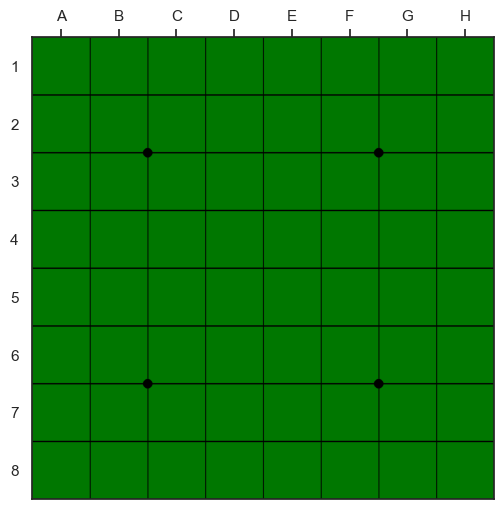

In [ ]:
# 環境の作成
env = othello.make()
env

上記のように、オセロ環境は初期状態ではディスクが配置されていない。ここでも`gymnasium`と同様に`reset`関数を呼び出すことで、ゲーム環境が初期化される。

なお、オセロのプレイヤーや盤の情報などは全て変数`env`の中に`env.player`ならびに`env.board`として格納されており、`gymnasium`と異なっているので注意すること。

In [ ]:
env.reset()

In [ ]:
print(env.player)

BLACK


In [ ]:
print(env.board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


また、Jupyter Notebook環境においては`env`を表示することで盤面を表わす画像が表示されるようになっている。

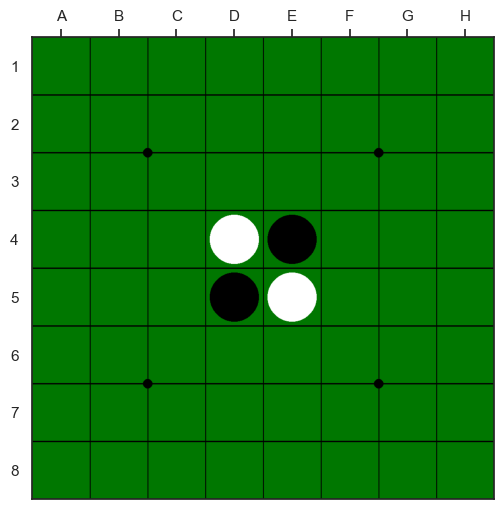

In [ ]:
env

## ランダムな着手

まずは、オセロ環境の仕様を理解するために、白番、黒番ともにランダムに行動させて、どのように状態が変化するかを見てみよう。

`env`には、現在の盤の状態で取ることができる「有効手」の配列を取得する`legal_actions`関数が提供されている。

In [ ]:
actions = env.legal_actions()
print(actions)

[BLACK 4 C, BLACK 3 D, BLACK 6 E, BLACK 5 F]


In [ ]:
actions[0]

BLACK 4 C

上記の出力から、黒番が3行5列、4行6列、5行3列、6行4列の4箇所のいずれかにディスクを置くことができることが分かる。

着手を決定したら、`env.update`関数に手を表す変数を渡すと盤の状態が更新される。

In [ ]:
env.update(actions[0])

In [ ]:
print(env.player)

WHITE


In [ ]:
print(env.board)

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  1  0  0  0]
 [ 0  0  0  1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


`env`のJupyter Notebook環境における表示により、黒番が3行5列にディスクを置いたことで、着手したセルがハイライトされて、かつ、盤の状態が正しく更新されていることが確認できる。

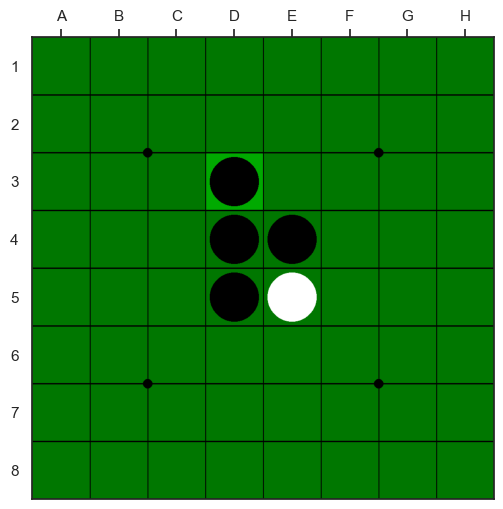

In [ ]:
env

オセロはルール上、着手可能な手がない、すなわちどこにディスクを置いても裏返せる相手方のディスクが存在しない時にはパスをすることになる。

有効手が存在しない時には`legal_actions`が長さが1でパスを表す手を含む配列を返してくる。その手 (`Action`)がパスの手かどうかは`is_pass()`で判定できる。

これらを踏まえて、黒番、白番ともにランダムに着手させて、盤の状態変化を確認する。

In [ ]:
# ゲームのリセット
env.reset()
frames = []

# エピソード開始
while not env.is_done():
    # 現在の状態画像を保存
    img = env.render()
    frames.append(img)

    # 有効手の列挙
    actions = env.legal_actions()

    # 着手可能な手があればランダムに1つを選ぶ
    action = np.random.choice(actions)

    # 着手による盤の状態の更新
    env.update(action)

In [ ]:
# アニメーションの描画
fig, ax = plt.subplots()
ax.set(xticks=[], yticks=[])

# 各フレームの描画
draw = []
for i, f in enumerate(frames):
    ims = plt.imshow(f)
    draw.append([ims])
    fig.tight_layout()

# アニメーションの作成
ani = ArtistAnimation(fig, draw, interval=100, blit=True)
html = display.HTML(ani.to_jshtml())
display.display(html)

# Matplotlibのウィンドウを閉じる
plt.close()

最終的な状態において、黒番、白番がそれぞれ何個のセルを専有しているかは`count`関数により計算できる。

In [ ]:
print("#black:", env.count(Player.BLACK))
print("#white:", env.count(Player.WHITE))

#black: 28
#white: 36


最後に、両者ランダムに着手する場合に1000回対戦すると、どの程度の勝敗になるのかを調べてみる。ランダム対戦には少々時間がかかるため、以下のコードでは、`joblib`を用いて、並列実行により同時に複数の対局を行なっている。

なお、以下での利便性のため、ランダムに着手する関数として`action_by_random`を作成しておく。

In [ ]:
def action_by_random(env):
    """有効手の中からランダムに手を選ぶ"""
    actions = env.legal_actions()
    return np.random.choice(actions)

In [ ]:
check(action_by_random, action_by_random)
glue("rand_b_win", b_win)
glue("rand_w_win", w_win)
glue("rand_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

51

42

7

**対局結果: ランダム vs ランダム**
- 黒番勝ち: {glue:}`rand_b_win`
- 白番勝ち: {glue:}`rand_w_win`
- 引き分け: {glue:}`rand_draw`

このようにランダムな着手では当然ながら、勝率はおよそ五分五分になる。以後は、この着手の方法を改良していき、より高い勝率を目指してみる。

:::{admonition} オセロが解けた？
:class: note

2023年10月に「Othello is Solved」という衝撃的なタイトルの論文が、プレプリント投稿サイトのarXivに公開された。この論文は、オセロゲームが「弱解決」したことを示している論文で、「弱解決」とは両対局者が常に最善の手を指し続けると、結果がどうなるかが解析できたことを示す。

人間の体感としては後手の方が(最後にディスクをおけるという意味で)若干有利のように感じるが、この論文によれば、オセロは、**両者が最善手を指し続けると引き分けになる**そうだ。興味のある読者は是非、以下の原著を読んでみてほしい。

Othello is Solved: <https://arxiv.org/abs/2310.19387>
:::

## セル評価値を用いた着手

人間(の初心者)がオセロを指すときに最初に覚えることと言えば、角が取れるように着手を調整する、ということだろう。

角のセルは一度ディスクを置いてしまえば、それ以降、相手に取られることがなく、また縁の領域にあるディスクを一度に多くひっくり返すこともできるため、角にディスクを置くことができれば有利になることが多い。

一方で、角のセルに隣接するセルにディスクを置くと、相手に角を取られる可能性が出てくるので、角に隣接するセルにはできる限りディスクを置かない方が良いことが分かる。

このような人間の経験則に従って、各セルにディスクを置くことが、どのくらい得でどのくらい損なのかを表わす評価値を以下のように定義する。

In [ ]:
SCORE_BOARD = np.array(
    [
        [120, -20, 20, 5, 5, 20, -20, 120],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [5, -5, 3, 0, 0, 3, -5, 5],
        [20, -5, 15, 3, 3, 15, -5, 20],
        [-20, -40, -5, -5, -5, -5, -40, -20],
        [120, -20, 20, 5, 5, 20, -20, 120],
    ],
    dtype="float64",
)

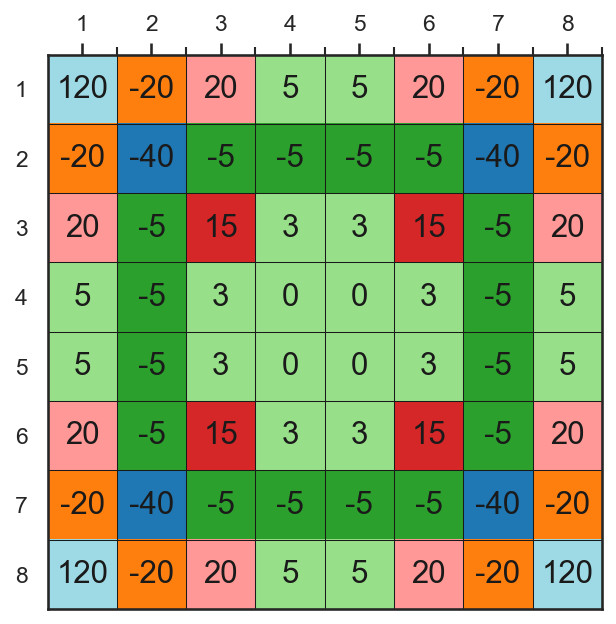

In [ ]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 8))
ax.set_yticks(np.arange(0, 8))
ax.set_xticklabels(np.arange(1, 9))
ax.set_yticklabels(np.arange(1, 9))

ax.set_xticks(np.arange(1, 9) - 0.5, minor=True)
ax.set_yticks(np.arange(1, 9) - 0.5, minor=True)

ax.imshow(SCORE_BOARD, cmap="tab20", interpolation=None)
for (i, j), z in np.ndenumerate(SCORE_BOARD):
    txt = ax.text(j, i, f"{int(z):d}", ha="center", va="center", color="k", fontsize=15)

ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
ax.xaxis.tick_top()

glue("cell_scores", fig)
plt.close()

:::{glue:figure} cell_scores
:figclass: image-stylish sm:w-full md:w-1/2
:name: "オセロ盤のセル評価値"
:::

In [ ]:
def action_by_score(env):
    """セル評価値を用いた着手"""
    actions = env.legal_actions()
    best_action = actions[0]
    best_score = -np.inf
    for action in actions:
        if action.is_pass():
            continue

        score = SCORE_BOARD[action.x, action.y]
        if best_score < score:
            best_action = action
            best_score = score

    return best_action

このルーチンを用いて、先ほどと同様に{glue:}`n_episodes`回の対戦を行ない、ランダムな着手に比べて、どのくらい勝率が上昇するかを見てみよう。

In [ ]:
check(action_by_score, action_by_random)
glue("score_b_win", b_win)
glue("score_w_win", w_win)
glue("score_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

73

23

4

**対局結果: セル評価値 vs ランダム**
- 黒番勝ち: {glue:}`score_b_win`
- 白番勝ち: {glue:}`score_w_win`
- 引き分け: {glue:}`score_draw`

上記の通り、人間の経験則を導入することでランダムに着手するのと比べて大幅に勝率が上昇していることが分かる。

(ssec:minimax)=
## ミニマックス探索

上記のセル評価値に基づく着手では、今まさに打とうとしている手が、**その時点においてどのくらいの価値を持つのか**だけを考慮していた。

しかし、実際には、局面によっては、角に単にセルの評価値が高いディスクに置くよりも、その後、何手か指した後に、より勝ちの高い手が打てるような手も存在するだろう。

実際に人間がオセロをプレイするときも、ある程度は「次に相手が何を」してくるかを考えているはずである。

説明を分かりやすくするために、黒番の手を探索することとすると、次のような前提が考えられる。

- 黒の手番では、手を指した後の盤面の「黒にとっての」評価値が**最大**になるように指す (自分に取って得な手を指す)
- 白の手番では、手を指した後の盤面の「黒にとっての」評価値が**最小**になるように指す (相手に取って損な手を指す)

このような考え方に基づいて、手を先読みして着手を探索する手法が**ミニマックス探索**である (min-max探索ではないので注意)。

In [ ]:
def score_fn(env, current_player):
    """
    current_playerにとっての評価値を返す
    """
    if current_player.is_black():
        return np.sum(env.board * SCORE_BOARD)
    elif current_player.is_white():
        return -np.sum(env.board * SCORE_BOARD)
    else:
        raise ValueError("Invalid player")


def minimax(env, current_player, depth):
    """
    current_playerにとって一番都合が良いスコアを返す
    """

    if env.is_done() or depth == 0:
        # ゲームが終了しているか、深さが0に達したら評価値を返す
        return score_fn(env, current_player)

    # 現在の手番によって最大を取るか、最小を取るかを切り替える
    actions = env.legal_actions()
    if env.player == current_player:
        # 現在の手番が自分なら最大値を取る
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, depth - 1)
            env.undo()
            best_score = max(best_score, v)
    else:
        # 現在の手番が相手なら最小値を取る
        best_score = np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, depth - 1)
            env.undo()
            best_score = min(best_score, v)

    return best_score

In [ ]:
def action_by_minimax(env, depth=2):
    """ミニマックス法に基づく着手"""

    current_player = env.player
    actions = env.legal_actions()

    best_score = -np.inf
    best_action = actions[0]
    for action in actions:
        env.update(action)
        v = minimax(env, current_player, depth)
        env.undo()

        if best_score < v:
            best_score = v
            best_action = action

    return best_action

In [ ]:
check(action_by_minimax, action_by_random)
glue("minimax_b_win", b_win)
glue("minimax_w_win", w_win)
glue("minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

84

14

2

**対局結果: ミニマックス vs ランダム**
- 黒番勝ち: {glue:}`minimax_b_win`
- 白番勝ち: {glue:}`minimax_w_win`
- 引き分け: {glue:}`minimax_draw`

上記の通り、ミニマックス探索で2手先を読むだけで飛躍的に勝率が上昇していることが分かる。

一方で、ミニマックス探索は現在の手番と探索中の盤面の手番の関係によって、盤面評価値の最大値を取るか最小値を取るかを切り替える必要があり、やや実装が複雑である。

このような実装上の問題を解決したのが**ネガマックス探索**であり、ミニマックス探索と同様の探索をより簡易なコードで実現することができる。詳細については解説した書籍やウェブページが多数存在するのでそちらを参照してほしい。

(ssec:alpha-beta)=
## アルファベータ探索

ただし、ミニマックス探索は再帰的に手を探索するため、より多くの手を読もうとすると、かなり多くの時間を要する。実際、ミニマックス探索は「本来探索する必要のない手」も探索しているがために、余計に計算を行なっている。

ミニマックス探索は、現在の局面から先の手を読むときに、相手も自分自身に取って最善となるように手を検討する。そのため、相手の手の評価値は検討を進めるに従って**相手にとっての価値は上昇していく**一方で、**自分にとっての価値は減少していく**ことが分かる。

従って、今得られている価値が最大の手の評価値より、相手の手の探索中に得られる評価値が小さくなった瞬間に、それ以上手を探索する必要がなくなる。このような原理に基づいて探索の枝刈りを行なう手法に**アルファベータ探索**がある。

アルファベータ探索は上記の`minimax`関数を少し改良するだけで実装できるので、練習問題として取り組んでみて、探索の効率が上昇することを確認してほしい。

In [ ]:
def alpha_beta(env, current_player, depth, alpha, beta):
    """
    current_playerにとって一番都合が良いスコアを返す
    """

    if env.is_done() or depth == 0:
        # ゲームが終了しているか、深さが0に達したら評価値を返す
        return score_fn(env, current_player)

    # 現在の手番によって最大を取るか、最小を取るかを切り替える
    actions = env.legal_actions()
    if env.player == current_player:
        # 現在の手番が自分ならアルファを更新
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, depth - 1, alpha, beta)
            env.undo()
            alpha = max(alpha, v)
            # ベータカット
            if alpha >= beta:
                break

        return alpha

    else:
        # 現在の手番が相手ならベータを更新
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, depth - 1, alpha, beta)
            env.undo()
            beta = min(beta, v)
            # アルファ・カット
            if alpha >= beta:
                break

        return beta

In [ ]:
def action_by_alpha_beta(env, depth=2):
    """アルファベータ法に基づく着手"""

    current_player = env.player
    actions = env.legal_actions()

    best_score = -np.inf
    best_action = actions[0]
    for action in actions:
        env.update(action)
        v = alpha_beta(env, current_player, depth, -np.inf, np.inf)
        env.undo()

        if best_score < v:
            best_score = v
            best_action = action

    return best_action

In [ ]:
check(action_by_alpha_beta, action_by_minimax)
glue("ab_vs_minimax_b_win", b_win)
glue("ab_vs_minimax_w_win", w_win)
glue("ab_vs_minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

51

49

0

しかし、この結果から分かる通り、アルファベータ探索はあくまでミニマックス探索を効率化したものであり、探索の深さが変わらない場合には強さは変わらない。

次項では、アルファベータ探索の効率を活かすために、適応的に探索の深さを変更する手法を見てみる。

(ssec:iterative-deepening)=
## 反復深化

In [ ]:
def action_by_minimax(env, time_limit=1.0e-2):
    """反復深化版ミニマックス法"""

    current_player = env.player
    actions = env.legal_actions()

    max_depth = 0
    start_time = time.perf_counter()
    best_action = actions[0]
    while time.perf_counter() - start_time < time_limit:
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = minimax(env, current_player, max_depth)
            env.undo()

            if best_score < v:
                best_score = v
                best_action = action

        max_depth += 1

    return best_action

In [ ]:
def action_by_alpha_beta(env, time_limit=1.0e-2):
    """反復深化版アルファベータ法"""

    current_player = env.player
    actions = env.legal_actions()

    max_depth = 0
    best_action = actions[0]
    start_time = time.perf_counter()
    while time.perf_counter() - start_time < time_limit:
        best_score = -np.inf
        for action in actions:
            env.update(action)
            v = alpha_beta(env, current_player, max_depth, -np.inf, np.inf)
            env.undo()

            if best_score < v:
                best_score = v
                best_action = action

        max_depth += 1

    return best_action

In [ ]:
check(action_by_alpha_beta, action_by_minimax)
glue("ab_vs_minimax_b_win", b_win)
glue("ab_vs_minimax_w_win", w_win)
glue("ab_vs_minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

93

7

0

(ssec:monte-carlo)=
## 原始モンテカルロ探索

ここまでに紹介したミニマックス法やアルファベータ法は、現在の状態に対して何らかの評価値が既に与えられている場合には有効であるものの、このような評価値を**どのように決定すれば最適なのか**は実際のところ難しい。

特に上記の例では、オセロ盤の状態ではなく、セルに対して評価値を与えているが、実際のオセロにおいて、どのセルにディスクを置けばより勝ちに近づくかは、そのときに既に置かれているディスクに依存するだろう。

従って、ここまでのセルの評価値に基づく探索には限界があり、**実際に勝てるのかどうか**に基づいた着手を目指す必要があると分かる。しかし、勝ち負けを知るためにはオセロを終局までプレイしなければならない。では、その過程ではどのような手を指せば良いだろうか。

**原始モンテカルロ探索**は、モンテカルロ法、すなわちランダムな着手によって、今の**オセロ盤の状態がどの程度、勝ちやすい、負けやすい状態なのかを近似的に推測しながら着手する手法**である。言い換えれば、どのような手が良いのかは一旦おいておいて、**適当に指しても勝ちやすければ、それが勝ちやすい局面**と見なして着手を決定する。

今、とあるオセロの局面を考えたとき、着手できる手は通常複数ある。このような複数の手をランダムに指して、どの手がより勝ちに近づくかを推定するのだが、この問題は、まさに**多腕バンディット問題**と同様の問題であることが分かる。多腕バンディット問題においては、どのスロットアームを回すかを最適化していたが、今回はオセロの有効手に対して同様の操作を行なう。

まず、とある局面からランダムにプレイを行なって終局まで進める操作を関数として定義しておく。このような操作を**プレアウト**と呼ぶ。

In [ ]:
def playout(env):
    """ランダムに着手して終局まで進める"""
    while not env.is_done():
        actions = env.legal_actions()
        action = random.choice(actions)
        env.update(action)

この関数を呼び出して、とある局面を終局まで進めたとき、今の手番のプレイヤーが勝ちなら **+1点** の報酬を得ることとする。

プレイアウトをするべき手は多腕バンディット問題において、良い性能であったUCB1値を用いて選択する。UCB1値の定義を再掲しておく。

$$
\text{UCB1}_i = \frac{n_{i,{\rm hit}}}{n_{i,{\rm play}}} + \sqrt{\frac{2 \log(n_{\rm total})}{n_{i, {\rm play}}}}
$$

この定義は多腕バンディット問題用の表記になっているが、これをオセロの着手に置き換えると、個々の変数は以下のものを指す。

- $n_{i, {\rm hit}}$: $i$番目の候補手を指してプレイアウトしたときの勝利回数
- $n_{i, {\rm play}}$: $i$番目の候補手に対してプレイアウトをした回数
- $n_{\rm total}$: 全ての候補手に対するプレイアウト数の合計

以下、UCB1値は定義上、$n_{i, {\rm play}}$ 即ち、各候補手に対するプレイアウト回数が1回以上ないと計算できないので、UCB1を用いた原始モンテカルロ法においては、

1. 各候補手に対して1回ずつプレイアウトを実行
1. 以下、UCB1値を計算し、その値が最大の候補手に対してプレイアウトを実行

という流れでどの候補手が最も勝ちやすいのかを推測していく。

このプレイアウト操作を予め決められた回数 (以下の実装では `n_trials=20` 回) 実行したら、プレイアウトされた回数が最大の手が最適な手であると判断する。プレイアウトされた回数が最大である、ということは、UCB1値を用いた探索において、最も有望な手であるということに留意している。

In [ ]:
def action_by_monte_carlo(env, n_trials=20):
    """
    原始モンテカルロ法に基づく着手
    """

    actions = env.legal_actions()
    n_wins = [0] * len(actions)
    n_checks = [0] * len(actions)
    for t in range(n_trials):
        # まだ調べていない手があるときはその手を調べる
        action_idx = -1
        for i, n in enumerate(n_checks):
            if n == 0:
                action_idx = i
                break
        else:
            # 全ての有効手を最低1回調べたら、UCB1値に基づいて着手
            ucb1_vals = []
            for w, n in zip(n_wins, n_checks):
                ucb1 = w / n + np.sqrt(2.0 * np.log(t) / n)
                ucb1_vals.append(ucb1)
            action_idx = np.argmax(ucb1_vals)

        # 手を進めてプレイアウトする
        env_cpy = env.copy()
        env_cpy.update(actions[action_idx])
        playout(env_cpy)

        # UCB1値計算用のチェック回数と勝利数を更新
        n_checks[action_idx] += 1
        if env_cpy.is_win(env.player):
            n_wins[action_idx] += 1

    # プレイアウト回数が最大の手を返す
    return actions[np.argmax(n_checks)]

In [ ]:
check(action_by_monte_carlo, action_by_random)
glue("mc_b_win", b_win)
glue("mc_w_win", w_win)
glue("mc_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

90

9

1

**対局結果: 原始モンテカルロ vs ランダム**
- 黒番勝ち: {glue:}`mc_b_win`
- 白番勝ち: {glue:}`mc_w_win`
- 引き分け: {glue:}`mc_draw`

このように、セル評価値のような人間の前提知識に頼ることなく、原始モンテカルロ法により、高い勝率が得られていることが分かる。

しかし、原始モンテカルロ探索をミニマックス探索と対戦させてみると、まだ、その勝率はミニマックス探索に及ばないことが分かる。人間の事前知識は意外にも侮れない。

In [ ]:
check(action_by_monte_carlo, action_by_minimax)
glue("mc_vs_minimax_b_win", b_win)
glue("mc_vs_minimax_w_win", w_win)
glue("mc_vs_minimax_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

36

61

3

**対局結果: 原始モンテカルロ(黒番) vs ミニマックス (白番)**
- 黒番勝ち: {glue:}`mc_vs_minimax_b_win`
- 白番勝ち: {glue:}`mc_vs_minimax_w_win`
- 引き分け: {glue:}`mc_vs_minimax_draw`

## モンテカルロ木探索

原始モンテカルロの弱点は、**自分の候補手に対してしか有望な手を考えていない**という点にある。原始モンテカルロにおいては、自分が候補手を指したあとは**自分も相手もランダムに着手する**と仮定しているが、実際の対局においては、自分も相手も、より勝ちやすい手を指すのが普通だろう。

**モンテカルロ木探索**は、上記の問題を解決するために、自分に対しても相手に対しても原始モンテカルロ同様にUCB1値に基づいて最善手を推定する手法である。

ここで「木探索」という用語が出てくるが、モンテカルロ木探索では[ゲーム木](https://ja.wikipedia.org/wiki/%E3%82%B2%E3%83%BC%E3%83%A0%E6%9C%A8)と呼ばれる木構造の中で手を探索する。ゲーム木では「局面を表すノード」が「その局面における候補手を指すことで得られる次局面を表すノード」とツリー状に接続されている。

UCB1値を使って候補手の探索を行なう場合、この木構造を特に**UCT** (Upper Confidence Tree)と呼ぶ。

以下の`action_by_mcts`関数は、今の局面 `env`に対してUCTの根ノードを作成し、候補手に対応する子ノードを探索するものである。

In [ ]:
def action_by_mcts(env, n_trials=20):
    """
    モンテカルロ木探索に基づく着手
    """

    # ノードと直接の子ノードの作成
    root_node = UctNode(env)
    root_node.expand_child_nodes()

    # 評価を繰り返す
    for _ in range(n_trials):
        root_node.evaluate()

    # 最も評価回数の多いノードを選ぶ
    n_list = []
    for node in root_node.child_nodes:
        n_list.append(node.n_check)

    actions = env.legal_actions()
    return actions[np.argmax(n_list)]

具体的な実装は後述するが、まずはおおまかなモンテカルロ木探索のアルゴリズムの流れについて見ていこう。

`action_by_mcts`関数の中では、現在の局面 `env`に対応する `root_node`を作成した後、`expand_child_nodes`を呼び出して、候補手に対するUCTのノードを作成している。

その後、`root_node`に対して `evaluate`関数を呼び出し、候補手のUCB1値に基づく探索を実施する。最後に、最も評価された回数が多い候補手を最善手であるとして選択する。

以上のように子ノードの展開 (`expand_child_nodes`)と子ノードのUCB1値に基づく探索 (`evaluate`)を除けば、大きなアルゴリズムの流れは原始モンテカルロ探索と共通していることを確認してほしい。

では、上記の流れを踏まえて、UCTのノードの実装を見ていこう。以下はやや長いコードになるが、全体の実装を掲載した後で、各メソッドに解説を加えていく。

In [ ]:
class UctNode(object):
    """
    UCB1値を用いた子ノードの探索を行うノード
    """

    # 子ノードを展開するまでのチェック回数
    N_VALID_CHECKS = 10

    def __init__(self, env):
        self.player = env.player
        self.env = env.copy()
        self.n_check = 0
        self.value = 0
        self.child_nodes = []

    def evaluate(self):
        """
        現在の盤に対する最善手を探索し、評価値を算出
        """

        if self.env.is_done():
            # ゲーム終了なら勝敗に応じて報酬を返す
            if self.env.is_win(self.player):
                value = 1
            elif self.env.is_lose(self.player):
                value = -1
            else:
                value = 0

            self.value += value
            self.n_check += 1
            return value

        elif len(self.child_nodes) == 0:
            # 評価回数が不十分ならプレイアウトをして報酬を計算
            value = self.playout()
            self.value += value
            self.n_check += 1

            # チェック回数が十分になったら子ノードを展開する
            if self.n_check >= self.N_VALID_CHECKS:
                self.expand_child_nodes()

            return value

        else:
            # 子ノードがあればUCB1値に基づいて相手の手を選択・評価
            value = -self.choose_next_action().evaluate()
            self.value += value
            self.n_check += 1

            return value

    def playout(self):
        """
        ランダムにプレイアウトをして評価値を取得
        """

        env = self.env.copy()
        while not env.is_done():
            actions = env.legal_actions()
            action = np.random.choice(actions)
            env.update(action)

        if env.is_win(self.player):
            return 1
        elif env.is_lose(self.player):
            return -1
        else:
            return 0

    def expand_child_nodes(self):
        """
        次の候補手に対応する子ノードを作成する
        """

        actions = self.env.legal_actions()
        for a in actions:
            self.env.update(a)
            new_node = UctNode(self.env)
            self.child_nodes.append(new_node)
            self.env.undo()

    def choose_next_action(self):
        """
        プレイアウトを実施する候補手の選択
        """

        # 評価回数が0回のノードがあったら、それを返す
        # (そうしないとUCB1値が計算できない)
        for node in self.child_nodes:
            if node.n_check == 0:
                return node

        # 子ノードの総評価回数
        t = 0
        for node in self.child_nodes:
            t += node.n_check

        # UCB1値の計算
        ucb1_values = []
        for node in self.child_nodes:
            # 子ノードの評価値は相手の手の評価値なので-1を掛けていることに注意
            ucb1 = -node.value / node.n_check + np.sqrt(2.0 * np.log(t) / node.n_check)
            ucb1_values.append(ucb1)

        return self.child_nodes[np.argmax(ucb1_values)]

`UctNode`のコンストラクタである `__init__` では、候補手の探索に必要な諸変数を初期化している。この中で、子ノードの配列は`child_nodes`であり、現在のノードの総評価回数が`n_checks`、子ノードの探索に基づく評価値 (本実装では総勝利回数)を`value`に格納している。

`evlauate`関数は、子ノードの探索に基づいて、現在のノードの評価値を算出する関数である。この評価値の探索には、以下の3つのパターンが考えられる。

1. 盤の状態が終局に達している → 勝ち負けに基づいて評価値を計算
2. プレイアウトによる価値評価回数が不十分 → 現局面からプレイアウトして局面を評価
3. プレイアウトによる価値評価回数が十分 → 有望な候補手である可能性が高いので、子ノードを更に探索

まずは、盤の状態が終局に達している場合で、これ以上プレイアウトが実行できないので、単純に勝ち負けに基づいて評価値を算出する。

終局に達していない場合には、手の探索を行って価値評価を行なうことになるが、ここで、ノードの評価回数に基づいて処理を分ける。今、とある盤の評価回数が一定以上である、ということは、**その盤状態に至る着手がそれなりに有望である**ことを意味している。逆に評価回数が一定以下であるときには、**その盤状態に至る着手が有望かどうか判断しかねる**状況であると言える。

子ノードを展開すると、評価しなければならないノード数が増加して、その分だけ他のノードの評価回数が減ってしまうので、できる限り有望な手に対してだけ、その後の局面を評価する方が望ましい。従って、上記の`evaluate`関数では、評価回数が一定以上 (`N_VALID_CHECKS=10`以上)の時だけ、子ノードを作成・探索するようにしている。

`playout`関数は原始モンテカルロ探索で用いた同名の関数を改良し、直接勝ち負けに基づいた評価値を返すようにしたものである。

`expand_child_nodes`関数は、現在の局面における候補手を列挙して、その手に対応するノードを作成する関数である。この際、次の局面を調べるために`env`の`update`と`undo`がペアで呼び出されていることに注意してほしい。

`choose_next_action`関数はUCB1値に基づいて、どの子ノードに対して評価を実施するかを決定する関数である。原始モンテカルロの時と同様、UCB1値は全ての子ノードの評価回数が最低1回はないといけないので、まず全子ノードの評価を実行し、以後はUCB1値に基づいて、どの子ノードを調べるかを決定している。

以上が、モンテカルロ木探索の全体像であるが、再帰的な探索など、やや高度な内容を含むので、何度もコードと解説を読み直して理解に努めてみてほしい。

では、このモンテカルロ木探索をミニマックス探索と対戦させて、実力を確かめてみよう。

In [ ]:
check(action_by_mcts, action_by_minimax)
glue("mcts_b_win", b_win)
glue("mcts_w_win", w_win)
glue("mcts_draw", draw)

  0%|          | 0/100 [00:00<?, ?it/s]

51

39

10

**対局結果: モンテカルロ木探索 (黒番) vs ミニマックス (白番)**
- 黒番勝ち: {glue:}`mcts_b_win`
- 白番勝ち: {glue:}`mcts_w_win`
- 引き分け: {glue:}`mcts_draw`

上記の通り、相手の手や、その後に続く自分の手に対してもUCB1値に基づく有望手の推定を行なうことで、ミニマックス法と同程度の強さを実現することができた。上記の例では、1手の探索に用いる手の評価回数を `n_trials=20` としているが、この数を増やすと、着手に時間はかかるようになる分、より勝ちやすい手が選べるようになる。

::::{admonition} 問
:class: question

原始モンテカルロ探索やモンテカルロ木探索において、プレイアウトする手の選択方法をUCB1値でない方法 ($\varepsilon$-greedy法やソフトマックス探索)に置き換えた時、オセロAIの強さはどの程度変化するか調べよ。

::::